# Homework 2
## Social Media Analytics

Clarissa Franklin, Kyle Katzen, Paige McKenzie, Meyappan Subbaiah

### Task A.
We brainstormed a list of major political topics that we thought would be relevant from 1789-2018. Our list included eight topics: war, voting, equality, slavery, taxes, economy, transportation, and international relations. We believe that these are the major topics that will appear, but also expected approximately two additional topics to appear in the speeches that we did not include. For this reason, we chose to model 10 topics. 

### Task B. 
#### topic modelling with LDA

In [27]:
import pandas as pd
import os
from nltk.corpus import stopwords
from nltk.stem.porter import *
import nltk
import regex as re
import numpy as np
import gensim
import sklearn
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib

In [2]:
stemmer = PorterStemmer()

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


stop = stopwords.words('english')

        
df = pd.DataFrame(columns=['year', 'month', 'day', 'speaker', 'text'])

In [3]:
for filename in os.listdir("data"):
    with open(os.path.join("data", filename), 'r',encoding="utf8", errors='ignore') as book:
        s = pd.Series(filename.split(' ',1)[0].split('-')+[filename.split(' ',1)[1][:-4], book.read()], 
                      index=['year', 'month', 'day', 'speaker', 'text'])
        df=df.append(s, ignore_index=True)

In [4]:
#test with small
#df=df[0:5]

df['text']=df['text'].apply(lambda x: re.sub("[^\w\s'+]",'', x)) 

In [5]:
df['text']=df['text'].apply(lambda x: [stemmer.stem(lemmatizer.lemmatize(item.lower())) for item in x.split() if item.lower() not in stop])

tf_vect=TfidfVectorizer(max_df=0.75, min_df=0.1)

df['text_joined']=df['text'].str.join(sep=" ")
x = tf_vect.fit_transform(df['text_joined']).todense()
tf_words=tf_vect.get_feature_names()

real_words=[]
for word in tf_words:
    first=word.split()[0]
    if first.isalpha():
        real_words+=[word]
real_words

#get frequency of words whole corpus
#init=[]
#corp=[i+init for i in df['text']][0]
#freq_dist = nltk.FreqDist(corp)

#also remove words that do not meet tf-idf thresholds (appear in nearly all documents, or are obscure words that do not appear in more than 10% of documents)
df['text'] = df['text'].apply(lambda x: [ word for word in x if word in real_words])

df.head()

,year,month,day,speaker,text,text_joined
0,1789,04,30,George Washington,"[fellow, citizen, senat, hous, repres, among, ...",fellow citizen senat hous repres among vicissi...
1,1789,10,03,George Washington,"[duti, acknowledg, provid, god, grate, benefit...",wherea duti nation acknowledg provid almighti ...
2,1790,01,08,George Washington,"[fellow, citizen, senat, hous, repres, embrac,...",fellow citizen senat hous repres embrac great ...
3,1790,12,08,George Washington,"[fellow, citizen, senat, hous, repres, meet, f...",fellow citizen senat hous repres meet feel muc...
4,1790,12,29,George Washington,"[written, speech, sign, hand, speak, desir, at...",presid unit state mouth written speech sign ha...


In [6]:
from gensim import corpora as cp
#create the term dictionary of our corpus, where every unique term is assigned an index
dictionary=cp.Dictionary(df['text'].values)

len(dictionary)
print(dictionary)
#convert list of documets into document term matrix using the dictionary

doc_term_matrix=[dictionary.doc2bow(doc) for doc in df['text'].values]

Dictionary(1703 unique tokens: ['accomplish', 'accordingli', 'acknowledg', 'act', 'actual']...)


In [7]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50,update_every=1)

#print the topics
topics=pd.DataFrame(ldamodel.print_topics(num_topics=10, num_words=6), columns=['topic', 'words_and_weights'])
topics.head()

,topic,words_and_weights
0,0,"0.029*""mr"" + 0.023*""think"" + 0.015*""vietnam"" +..."
1,1,"0.009*""problem"" + 0.009*""busi"" + 0.007*""public..."
2,2,"0.014*""upon"" + 0.014*""constitut"" + 0.013*""shal..."
3,3,"0.018*""law"" + 0.011*""busi"" + 0.011*""upon"" + 0...."
4,4,"0.012*""soviet"" + 0.007*""nuclear"" + 0.007*""unio..."


In [8]:
all_topics = ldamodel.get_document_topics(doc_term_matrix)

#### Distribution of Topics

In [10]:
topic_agg = []
for num,doc in enumerate(all_topics):
    topic_lst = [j[0] for j in doc]
    topic_agg.append(topic_lst)
df['topics'] = topic_agg

In [11]:
df.head()

,year,month,day,speaker,text,text_joined,topics
0,1789,04,30,George Washington,"[fellow, citizen, senat, hous, repres, among, ...",fellow citizen senat hous repres among vicissi...,"[2, 5]"
1,1789,10,03,George Washington,"[duti, acknowledg, provid, god, grate, benefit...",wherea duti nation acknowledg provid almighti ...,"[0, 2, 5]"
2,1790,01,08,George Washington,"[fellow, citizen, senat, hous, repres, embrac,...",fellow citizen senat hous repres embrac great ...,"[2, 5]"
3,1790,12,08,George Washington,"[fellow, citizen, senat, hous, repres, meet, f...",fellow citizen senat hous repres meet feel muc...,"[2, 5]"
4,1790,12,29,George Washington,"[written, speech, sign, hand, speak, desir, at...",presid unit state mouth written speech sign ha...,"[2, 3, 5, 8]"


In [12]:
def new_columns(i, lst):
    if i in lst:
        return 1
    else:
        return 0

for j in range(0,10):
    df['Topic_' + str(j)] = df['topics'].apply(lambda x: new_columns(j, x))

In [13]:
df.head()

,year,month,day,speaker,text,text_joined,topics,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,1789,04,30,George Washington,"[fellow, citizen, senat, hous, repres, among, ...",fellow citizen senat hous repres among vicissi...,"[2, 5]",0,0,1,0,0,1,0,0,0,0
1,1789,10,03,George Washington,"[duti, acknowledg, provid, god, grate, benefit...",wherea duti nation acknowledg provid almighti ...,"[0, 2, 5]",1,0,1,0,0,1,0,0,0,0
2,1790,01,08,George Washington,"[fellow, citizen, senat, hous, repres, embrac,...",fellow citizen senat hous repres embrac great ...,"[2, 5]",0,0,1,0,0,1,0,0,0,0
3,1790,12,08,George Washington,"[fellow, citizen, senat, hous, repres, meet, f...",fellow citizen senat hous repres meet feel muc...,"[2, 5]",0,0,1,0,0,1,0,0,0,0
4,1790,12,29,George Washington,"[written, speech, sign, hand, speak, desir, at...",presid unit state mouth written speech sign ha...,"[2, 3, 5, 8]",0,0,1,1,0,1,0,0,1,0


In [14]:
df.to_csv("topics_speech.csv")

Picture below created in R (code attached)

![title](Topics_over_time_perc.png)

### Distribution of words in each topic

In [ ]:
word_topic_dist = pd.DataFrame(columns=['Topic','word','weight'])

## https://stackoverflow.com/questions/17662916/how-to-print-out-the-full-distribution-of-words-in-an-lda-topic-in-gensim
for words in ldamodel.show_topics(formatted=False,num_words=10):
    topic_num = words[0]
    print(topic_num)
    for word_prob in words[1]:
        print(word_prob)
        row = [topic_num,word_prob[0],word_prob[1]]
        word_topic_dist = word_topic_dist.append({
     "Topic": topic_num,
     "word":  word_prob[0],
     "weight": word_prob[1]
      }, ignore_index=True)

In [67]:
test = word_topic_dist.groupby(['Topic']).apply(lambda x: x['weight']/x['weight'].sum())

In [68]:
word_topic_dist['weighted_numbers'] = test.values

In [69]:
word_topic_dist.to_csv("topic_word_weights.csv")

Note: This graph was produced in R, I will clean it up later. I spent the last hour looking up how to fix this order and it's only pissing me off more. Will do later.

![title](word_topic_dist.png)

Picture below created in R (code attached)

![title](Part_C_similarity_Pres_perc.png)

The most dramatic trend over time is the concentration of topics **2** and **5** near the founding of the United States, addressed heavily by the presidents who were also founding fathers (Washington, Adams, Jefferson, Madison, Monroe). These topics are heavily centered around the young republic's structure, with words like *constitution*, *union*, *law*, *congress*, and *public*.

Starting around Grover Cleveland's presidency, we see a shift from topics **2** and **5** primarily to a more diverse set of other topics.

Most recently, we see both Bush presients, Clinton, Obama, and Trump all heavily address topic **9**, which anybody who has been watching news in recent times will recognize, with prominent words like *tax*, *jobs*, and *healthcare*, the divisive topics in recent years.

### Task C
In terms of topics addressed "heavily" in a speech, which 3 former presidents does President Trump share the highest similarity with? How did you arrive at your conclusion?

In [2]:
df = pd.read_csv('topics_speech.csv', index_col=0)

In [55]:
cos = df.groupby('speaker')[df.columns[7:]].sum().T
cos.head()

speaker,Abraham Lincoln,Andrew Jackson,Andrew Johnson,Barack Obama,Benjamin Harrison,Bill Clinton,Calvin Coolidge,Chester Alan Arthur,Donald Trump,Dwight David Eisenhower,...,Rutherford Birchard Hayes,Theodore Roosevelt,Thomas Jefferson,Ulysses S. Grant,Warren Gamaliel Harding,William Henry Harrison,William Howard Taft,William McKinley,Woodrow Wilson,Zachary Taylor
Topic_0,10,2,0,3,1,21,0,0,6,2,...,0,0,3,3,0,1,0,1,4,0
Topic_1,1,0,0,8,0,9,3,0,1,2,...,1,5,1,1,3,0,0,3,8,0
Topic_2,14,11,1,4,1,2,4,0,1,6,...,5,5,22,5,3,1,1,4,19,1
Topic_3,9,3,1,3,5,5,7,3,4,1,...,5,9,2,10,3,1,7,5,16,0
Topic_4,0,0,0,4,2,14,5,2,4,6,...,1,1,0,0,2,0,5,5,9,0


In [56]:
from sklearn.metrics.pairwise import cosine_similarity
cos = pd.DataFrame(cosine_similarity(cos.values.T)-np.identity(44)*cosine_similarity(cos.values.T), 
                   columns=cos.columns, index=cos.columns)
cos.head()

speaker,Abraham Lincoln,Andrew Jackson,Andrew Johnson,Barack Obama,Benjamin Harrison,Bill Clinton,Calvin Coolidge,Chester Alan Arthur,Donald Trump,Dwight David Eisenhower,...,Rutherford Birchard Hayes,Theodore Roosevelt,Thomas Jefferson,Ulysses S. Grant,Warren Gamaliel Harding,William Henry Harrison,William Howard Taft,William McKinley,Woodrow Wilson,Zachary Taylor
speaker,,,,,,,,,,,,,,,,,,,,,
Abraham Lincoln,0.000000,0.766196,0.860916,0.515443,0.661685,0.513172,0.600781,0.449599,0.650668,0.742994,...,0.752180,0.771862,0.843900,0.791240,0.611132,0.953366,0.485071,0.675413,0.858984,0.666737
Andrew Jackson,0.766196,0.000000,0.797724,0.195386,0.676232,0.162104,0.657272,0.644735,0.228057,0.554876,...,0.876623,0.603983,0.915582,0.811631,0.637059,0.764471,0.630858,0.731241,0.688724,0.966988
Andrew Johnson,0.860916,0.797724,0.000000,0.444500,0.712069,0.360356,0.689202,0.609272,0.483046,0.631169,...,0.854704,0.852437,0.796182,0.832446,0.670820,0.894427,0.633866,0.693688,0.812699,0.707107
Barack Obama,0.515443,0.195386,0.444500,0.000000,0.411972,0.931362,0.482176,0.184232,0.882227,0.645085,...,0.226744,0.611902,0.386076,0.394169,0.498544,0.454369,0.218247,0.440492,0.620529,0.119737
Benjamin Harrison,0.661685,0.676232,0.712069,0.411972,0.000000,0.429914,0.904031,0.929665,0.556891,0.556444,...,0.770904,0.774137,0.635656,0.936705,0.743043,0.689968,0.932803,0.895291,0.778612,0.503509


In [57]:
cos['Donald Trump'].sort_values(ascending=False).head(3)

speaker
Bill Clinton            0.954103
Ronald Wilson Reagan    0.918691
George H. W. Bush       0.914082
Name: Donald Trump, dtype: float64

Using cosine similarity on the number of times each president gave a speech of each topic, we can see that Donald Trump's speeches are most similar to the distribution of speeches given by Bill Clinton, Ronald Reagan, and George W. Bush.

### Task D
In terms of his own speeches, do you see President Trump shifting the emphasis on certain topics over time? Explain your response. 

Picture below created in R (code attached)

![title](trump_speech_distribution.png)

It is difficult to make any statements about the change over time in Trump's speech topics, as there are so few speeches (8 in sample). We can, however, confidently point out that Trump's speeches tend to feature topics **8** and **9**, which feature words like *america*, *man*, and *freedom*, in keeping with his claim to be a populist.

### Task E
If you do a K-means clustering with the same number of clusters as topics, do you see President Trump's speeches and those of the 3 former presidents you identified in Task C in the same cluster? What was the basis of clustering (e.g., tf-idf, cosine similarity, etc.). Discuss your findings.   

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 10)
km_vec = TfidfVectorizer(max_df=0.75, min_df=0.1)
km_x = km_vec.fit_transform(df['text'].values)
km.fit(km_x)
km_results = [x for x in zip(df['speaker'].values, km.labels_)]
km_df = pd.DataFrame(dict(cluster = pd.Series(km.labels_), president = df["speaker"]))
km_results_counts = {}
for pres, clu in km_results:
    if pres not in km_results_counts.keys():
        km_results_counts[pres] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    km_results_counts[pres][clu] += 1
km_results[:10]

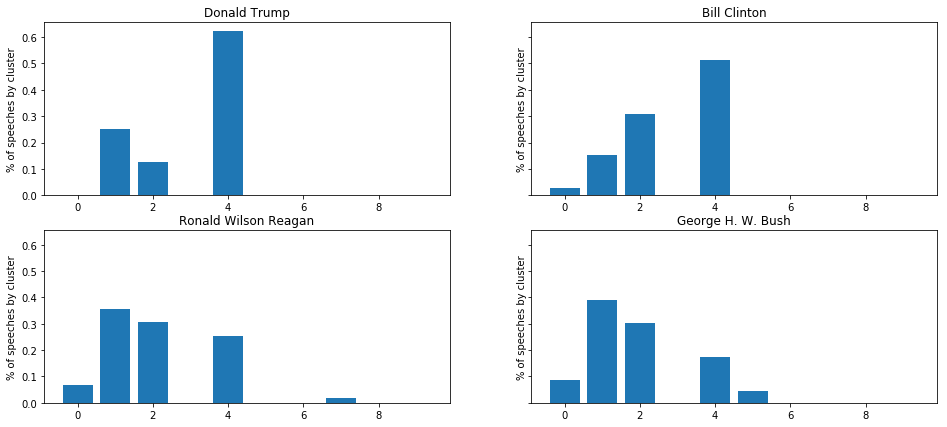

In [80]:
clust = pd.DataFrame(km_results_counts)
clust = clust.div(clust.sum())

fig, axes = plt.subplots(sharey=True, nrows=2,ncols=2, figsize=(16,7))

axes[0,0].bar(height=clust['Donald Trump'], x=clust.index)
axes[0,0].set_title('Donald Trump')
axes[0,0].set_ylabel("% of speeches by cluster")
axes[0,1].bar(height=clust['Bill Clinton'], x=clust.index)
axes[0,1].set_title('Bill Clinton')
axes[0,1].set_ylabel("% of speeches by cluster")
axes[1,0].bar(height=clust['Ronald Wilson Reagan'], x=clust.index)
axes[1,0].set_title('Ronald Wilson Reagan')
axes[1,0].set_ylabel("% of speeches by cluster")
axes[1,1].bar(height=clust['George H. W. Bush'], x=clust.index)
axes[1,1].set_title('George H. W. Bush')
axes[1,1].set_ylabel("% of speeches by cluster")

plt.show()

Clustering on the tf-idf scores for each speech's transcript, using 10 clusters as we used 10 topics before, we can see that the clustering produces very similar results to the topic modelling performed earlier, as the similar presidents identified earlier by topic have very similar distributions by cluster.

We can see that Donald Trump shares cluster **1**, **2**, and **4** overwhelmingly with Bill Clinton. This pair also had the highest similarity earlier, when we used cosine similarity to find presidents with similar topic distributions. Ronald Reagan and George H. W. Bush also have spikes in the same three clusters, **1**, **2**, and **4**, though their distribution is tilted towards clusters **1** and **2**, rather than cluster **4** like Clinton and Trump.

### Task F
Provide a visualization of both clusters (with colors) and cosine scores using MDS. 